In [1]:
import torch
import pandas as pd
from datasets import load_dataset, DatasetDict
from transformers import (
    AutoTokenizer, 
    TrainingArguments, 
    Trainer, 
    DataCollatorWithPadding, 
    EarlyStoppingCallback, 
    Seq2SeqTrainingArguments,
    AutoModelForSeq2SeqLM,
    Seq2SeqTrainer,
    AutoTokenizer
)
import os
import numpy as np
from transformers.integrations import TensorBoardCallback

import matplotlib.pyplot as plt
import seaborn as sns

/home/jovyan/work/venv/low-res/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jovyan/work/venv/low-res/lib/python3.10/site-packages/_distutils_hack/__init__.py:53: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


## Model loading

In [2]:
model = AutoModelForSeq2SeqLM.from_pretrained("facebook/nllb-200-distilled-600M", cache_dir="/home/jovyan/work/homeworks/diploma/nllb-train/nllb-200")
tokenizer = AutoTokenizer.from_pretrained(
    "facebook/nllb-200-distilled-600M", 
    src_lang="kaz_Cyrl", 
    tgt_lang="rus_Cyrl",
    cache_dir="/home/jovyan/work/homeworks/diploma/nllb-train/nllb-200",
)

## Test example

In [3]:
text = "Жергілікті радио жаңалықтары сағат сайын таратылады"
inputs = tokenizer(text, return_tensors="pt")
translated_tokens = model.generate(
    **inputs, 
    forced_bos_token_id=tokenizer.convert_tokens_to_ids("rus_Cyrl"), 
)
tokenizer.batch_decode(translated_tokens, skip_special_tokens=True)[0]

'Местные радиовещания распространяются каждый час'

## Freeze encoder

In [4]:
for param in model.model.encoder.parameters():
    param.requires_grad = False

## Load dataset

In [5]:
dataset = load_dataset("issai/kazparc", "kazparc", cache_dir="/home/jovyan/work/homeworks/diploma/nllb-train/data")

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'source_lang', 'target_lang', 'domain', 'pair'],
        num_rows: 1742956
    })
    validation: Dataset({
        features: ['id', 'source_lang', 'target_lang', 'domain', 'pair'],
        num_rows: 435742
    })
    test: Dataset({
        features: ['id', 'source_lang', 'target_lang', 'domain', 'pair'],
        num_rows: 28500
    })
})

In [7]:
dataset["train"] = dataset["train"].filter(lambda example: example["pair"] == "kk_ru")
dataset["validation"] = dataset["validation"].filter(lambda example: example["pair"] == "kk_ru")
dataset["test"] = dataset["test"].filter(lambda example: example["pair"] == "kk_ru")

In [8]:
dataset["train"][0]

{'id': 'LD051185LD',
 'source_lang': 'Салық органдарының лауазымды адамы куәгерлердің қатысуымен жасайтын хаттамада (актіде) әрекеттің мазмұны мен оны жүргізудің жүйелілігі көрсетіледі.',
 'target_lang': 'В протоколе (акте), составляемом должностным лицом налоговых органов с участием понятых, указываются содержание действия и последовательность его проведения.',
 'domain': 'legal_docs',
 'pair': 'kk_ru'}

In [9]:
train_df = pd.DataFrame(dataset['train'])
valid_df = pd.DataFrame(dataset['validation'])
test_df = pd.DataFrame(dataset['test'])

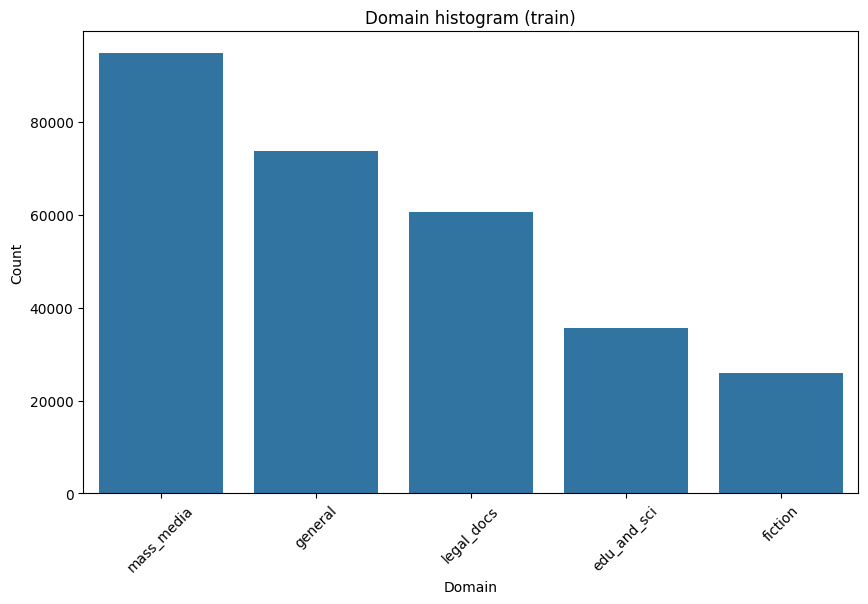

In [10]:
plt.figure(figsize=(10, 6))
sns.countplot(data=train_df, x='domain', order=train_df['domain'].value_counts().index)
plt.title('Domain histogram (train)')
plt.xlabel('Domain')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

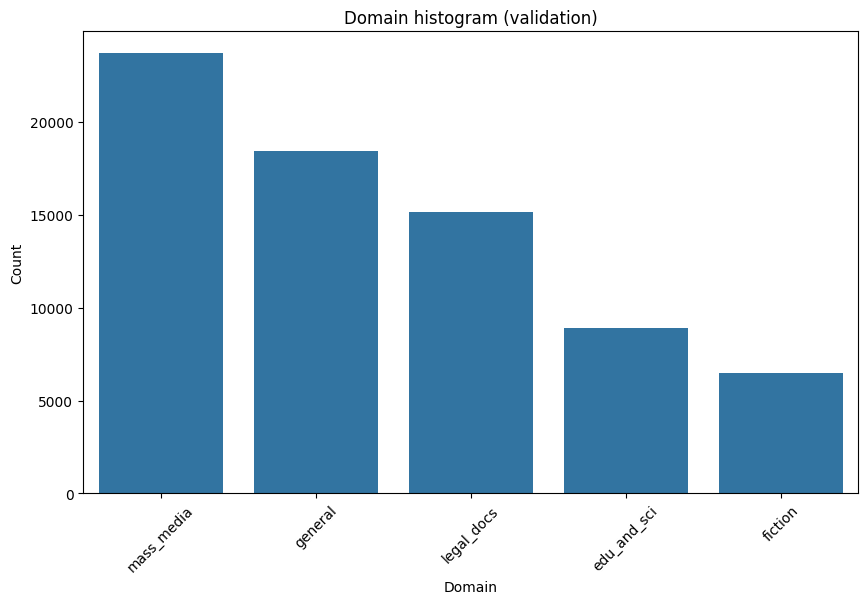

In [11]:
plt.figure(figsize=(10, 6))
sns.countplot(data=valid_df, x='domain', order=valid_df['domain'].value_counts().index)
plt.title('Domain histogram (validation)')
plt.xlabel('Domain')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

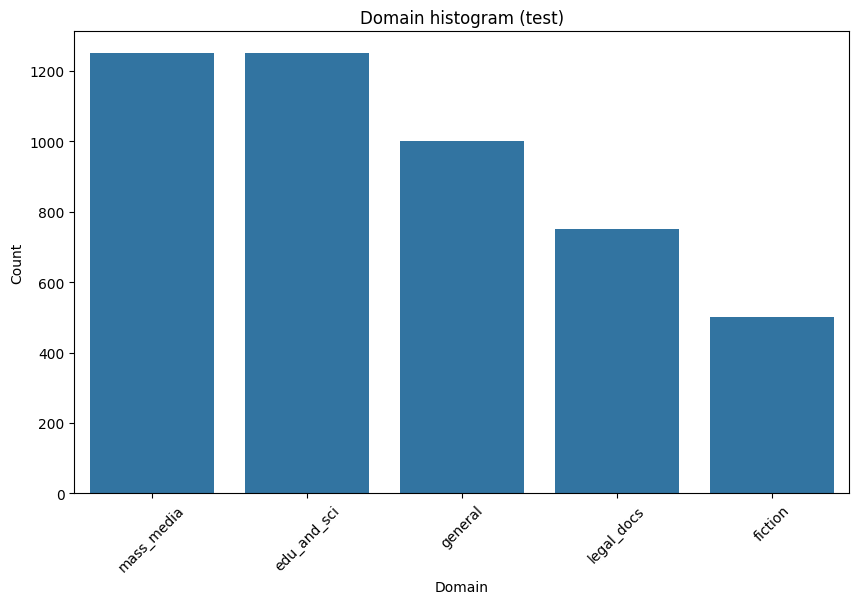

In [12]:
plt.figure(figsize=(10, 6))
sns.countplot(data=test_df, x='domain', order=test_df['domain'].value_counts().index)
plt.title('Domain histogram (test)')
plt.xlabel('Domain')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [13]:
train_df_cleaned = train_df.dropna(subset=['source_lang']).drop_duplicates(subset=['source_lang'])

In [14]:
len(train_df), len(train_df_cleaned)

(290785, 286943)

In [15]:
valid_df_cleaned = valid_df.dropna(subset=['source_lang']).drop_duplicates(subset=['source_lang'])

In [16]:
len(valid_df), len(valid_df_cleaned)

(72697, 72413)

In [17]:
test_df_cleaned = test_df.dropna(subset=['source_lang']).drop_duplicates(subset=['source_lang'])

In [18]:
len(test_df), len(test_df_cleaned)

(4750, 4750)

In [19]:
from datasets import Dataset

train_dataset = Dataset.from_pandas(train_df_cleaned)
valid_dataset = Dataset.from_pandas(valid_df_cleaned)
test_dataset = Dataset.from_pandas(test_df_cleaned)

dataset = DatasetDict({
    'train': train_dataset,
    'validation': valid_dataset,
    'test': test_dataset
})

In [20]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'source_lang', 'target_lang', 'domain', 'pair', '__index_level_0__'],
        num_rows: 286943
    })
    validation: Dataset({
        features: ['id', 'source_lang', 'target_lang', 'domain', 'pair', '__index_level_0__'],
        num_rows: 72413
    })
    test: Dataset({
        features: ['id', 'source_lang', 'target_lang', 'domain', 'pair'],
        num_rows: 4750
    })
})

In [21]:
dataset["train"][1]

{'id': 'FI018675FI',
 'source_lang': 'Бұл көбіне дәстүрлерді, ізін ала сот пен ақсүйектік мәселесінің тағдырын тығырыққа тіреді.',
 'target_lang': 'Отчасти для того, чтобы поставить под вопрос обычаи, а следовательно, авторитет суда и аристократии.',
 'domain': 'fiction',
 'pair': 'kk_ru',
 '__index_level_0__': 1}

In [22]:
dataset["train"] = dataset["train"].remove_columns("__index_level_0__")
dataset["validation"] = dataset["validation"].remove_columns("__index_level_0__")

## Training

In [23]:
tensorboard_callback = TensorBoardCallback()

In [24]:
MAX_LENGTH = 256

def tokenize_dataset(example, max_length=MAX_LENGTH):
    encodings = tokenizer(
        example['source_lang'], 
        truncation=True, 
        padding="max_length", 
        max_length=max_length,
        text_target=example['target_lang'],
    )
    return encodings

dataset = dataset.map(tokenize_dataset, batched=True)

Map: 100%|██████████| 4750/4750 [00:00<00:00, 5885.83 examples/s]


In [25]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'source_lang', 'target_lang', 'domain', 'pair', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 286943
    })
    validation: Dataset({
        features: ['id', 'source_lang', 'target_lang', 'domain', 'pair', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 72413
    })
    test: Dataset({
        features: ['id', 'source_lang', 'target_lang', 'domain', 'pair', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 4750
    })
})

In [26]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [27]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Tue Feb 18 08:45:17 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A40          On   | 00000000:01:00.0 Off |                    0 |
|  0%   31C    P8    11W / 300W |      0MiB / 46068MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A40          On   | 00000000:02:00.0 Off |                    0 |
|  0%   

In [ ]:
model_args = Seq2SeqTrainingArguments(
    output_dir="./output_dir",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    logging_steps=1000,
    evaluation_strategy="steps",
    num_train_epochs=3,
    learning_rate=2e-5,
    weight_decay=0.02,
    save_total_limit=1,
    predict_with_generate=True,
    report_to="none"
)

trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=tokenizer,
    args=model_args,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    callbacks=[tensorboard_callback],

)

trainer.train()

/home/jovyan/work/venv/low-res/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_2079/2432297082.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss,Validation Loss


/home/jovyan/work/venv/low-res/lib/python3.10/site-packages/transformers/modeling_utils.py:2758: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 200}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


## Eval

In [29]:
import evaluate

metric = evaluate.load("sacrebleu")